In [94]:
from pathlib import Path
from PIL import Image
import pandas as pd
import json
import os
from collections import namedtuple
import matplotlib.pyplot as plt
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image
import torchvision.transforms as T
import regex as re

# Pre-Processing & Summary Stats

In [95]:
# Getting the Path where the x-ray images are stored
current_dir = Path(os.getcwd())

# Get the parent directory of the current file
parent_dir = current_dir.parent

# Join the parent directory with the name of the adjacent folder
data_path = parent_dir.joinpath('data/chest_xray')

# Alternative Variable with data directory
alt_directory = '/Users/rubengallardo/Documents/GitHub/Spring_2024/ml_project/chest_xray'
#os.listdir(alt_directory)


os.listdir(data_path)

['.DS_Store', 'test', 'train', 'val']

In [96]:
Image_Stats =  namedtuple('Image_Stats', ["channels", "Label",
                                            "split", "label", "width", "height",
                                           "pixels_sq", "ratio", "image_name",
                                             "path"])

METRICS = ["widths", "heights", "pixels_sq", "ratios"]
def compile_stats(data_path):
    tup_list = []
    sum_stats = {}
    for folder_l1 in os.listdir(data_path):     
        #iterating through test, train, and val
        if folder_l1 in ('.DS_Store', '__MACOSX'):
            continue
        fl1 = os.path.join(data_path, folder_l1)
        
        # checking if it is a folder
        if not os.path.isdir(fl1):
            continue
        sum_stats[folder_l1] = {}
        for folder_l2 in os.listdir(fl1):
            #iterating through Normal and Pnemonia
            if folder_l2 == '.DS_Store':
                continue
            fl2 = os.path.join(fl1, folder_l2)
            if not os.path.isdir(fl2):
                continue
            sum_stats[folder_l1][folder_l2] = {}

            for filename in os.listdir(fl2):
                #iterating through images
                if filename == '.DS_Store':
                    continue
                f = os.path.join(fl2, filename)
                # checking if it is a file
                if not os.path.isfile(f):
                    continue
                
                
                image_obj = Image.open(f)

                #initializing empty lists of summary statistics
                for m in METRICS:
                    sum_stats[folder_l1][folder_l2][m] = sum_stats[folder_l1][folder_l2].get(m, [])

                #fillin in the summary statistics
                sum_stats[folder_l1][folder_l2]["widths"].append(image_obj.width)
                sum_stats[folder_l1][folder_l2]["heights"].append(image_obj.height)
                
                #counting the number of layers/ channels
                channels = image_obj.split()
                n_channels = len(channels)


                #calculating square pixels
                square_pixels = int(image_obj.height) * int(image_obj.width)
                sum_stats[folder_l1][folder_l2]["pixels_sq"].append(square_pixels)
                ratio = int(image_obj.width)/int(image_obj.height)
                sum_stats[folder_l1][folder_l2]["ratios"].append(ratio)
                
                # Converted labels to boolean attribute
                if  folder_l2 == 'PNEUMONIA':
                    img_label = 1
                else: 
                    img_label = 0
                
                # Checking if the Label is Bacteria or Virus
                if folder_l2 == 'PNEUMONIA':
                    str_path = str(filename)
                    if re.search("virus", str_path):
                        sick = "Virus"
                    else:
                        sick = "Bacteria"
                else:
                    sick = "Normal"

                tup =  Image_Stats( n_channels, sick,
                                    folder_l1, img_label, 
                                   image_obj.width, image_obj.height, 
                                   square_pixels, ratio, filename, f)
                tup_list.append(tup)

                del image_obj

    return sum_stats, tup_list

In [97]:
dic, tup_list = compile_stats(data_path)
df = pd.DataFrame(tup_list)


# Verify DataFrame
df.head(5)

,channels,Label,split,label,width,height,pixels_sq,ratio,image_name,path
0,1,Bacteria,test,1,1120,808,904960,1.386139,person147_bacteria_706.jpeg,/Users/gabrielbarrett/Code/ML/xray/data/chest_...
1,1,Bacteria,test,1,1040,696,723840,1.494253,person100_bacteria_482.jpeg,/Users/gabrielbarrett/Code/ML/xray/data/chest_...
2,1,Bacteria,test,1,1016,544,552704,1.867647,person78_bacteria_382.jpeg,/Users/gabrielbarrett/Code/ML/xray/data/chest_...
3,1,Bacteria,test,1,976,608,593408,1.605263,person124_bacteria_589.jpeg,/Users/gabrielbarrett/Code/ML/xray/data/chest_...
4,1,Virus,test,1,1168,768,897024,1.520833,person1647_virus_2848.jpeg,/Users/gabrielbarrett/Code/ML/xray/data/chest_...


In [98]:
#Presenting the averages for each summary statistic. 

df[["width", "height", "ratio", "channels"]].mean()

width       1327.880806
height       970.689037
ratio          1.442986
channels       1.096653
dtype: float64

array([[<Axes: title={'center': 'width'}>,
        <Axes: title={'center': 'height'}>],
       [<Axes: title={'center': 'ratio'}>,
        <Axes: title={'center': 'channels'}>]], dtype=object)

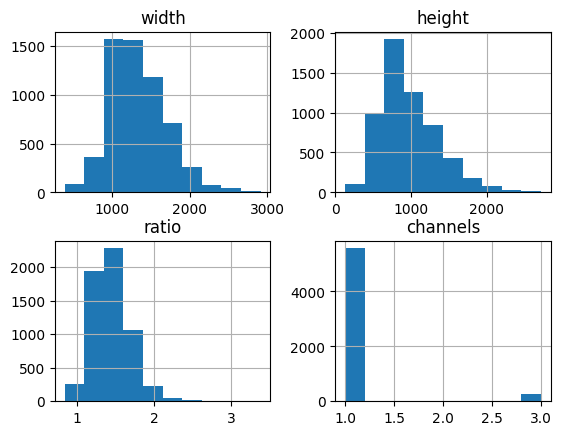

In [99]:
# Ploting the distributing of each summary statistic.
df[["width", "height", "ratio", "channels"]].hist()

Based on these summary statistics the vast majority of images are landscape, meaning that the width is longer than the height. Almost all the images have only one channel, meaning they are in greyscale, but it appears 283 images have three channels meaning their data is held in rgb. 

In [100]:
df_channels = df[["channels"]]
df_channels[df[["channels"]]==3].count()

channels    283
dtype: int64

# Image Transformations

In [101]:
# Custom PyTorch Image Dataset Class
# Resource: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir_path, transform=None):
        """
        You can set your custom dataset to take in more parameters than specified
        here. But, I recommend at least you start with the three I listed here,
        as these are standard

        df (pandas df): pandas dataframe
        img_dir_path: directory path to your images
        transform: Compose (a PyTorch Class) that strings together several
        transform functions (e.g. data augmentation steps)

        One thing to note -- you technically could implement `transform` within
        the dataset. No one is going to stop you, but you can think of the
        transformations/augmentations you do as a hyperparameter. If you treat
        it as a hyperparameter, you want to be able to experiment with different
        transformations, and therefore, it would make more sense to decide those
        transformations outside the dataset class and pass it to the dataset!
        """
        self.img_labels = df
        self.img_dir = img_dir_path
        self.transform = transform

    def __len__(self):
        """
        Returns: (int) length of your dataset
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """        
        img_path = os.path.join(self.img_labels.iloc[idx, -1])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]

        # Image Transformation
        if self.transform:
            image = self.transform(image)

        # Returns augmented and/or normalized image with label
        # Label = 1 if pneumonia and label = 0 if normal
        return image, label

In [102]:
# Augmentation for Training Data
augmentations = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),  # Horizontal flip with prob of 0.5
    T.RandomVerticalFlip(p=0.5),    # Vertical flip with prob of 0.5
    T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33)),  # Rescaling
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Shifts image horizontally or vertically by 10%
    T.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly changes brightness and contrast
    T.RandomRotation(degrees=10), # Random rotation
    T.ToTensor()  # Convert images to tensors
])

# Normalization for Validation and Test datasets
normalizations = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor() 
])
alt_directory = str(data_path)
print(alt_directory)

/Users/gabrielbarrett/Code/ML/xray/data/chest_xray


# Normalization and Augmentation Examples

### Original Sample Image

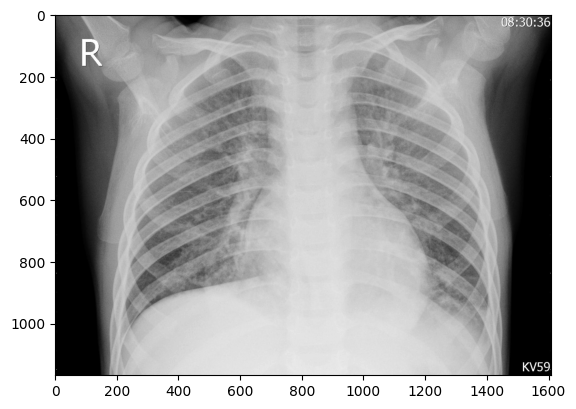

In [103]:
alt_directory = str(data_path)
# Random Horizontal Flip
image = read_image(alt_directory + '/train/PNEUMONIA/person141_virus_287.jpeg')

image = image.squeeze() # Remove the channel dimension because it's grayscale
plt.imshow(image, cmap='grey')  
plt.show() 

### Random Horizonal Flip

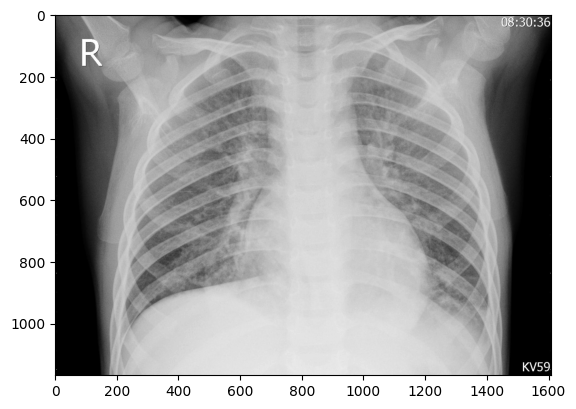

In [104]:
# Random Horizontal Flip with probability of 0.5
image = T.RandomHorizontalFlip(p=0.5)(image)

image = image.squeeze() # Remove the channel dimension because it's grayscale
plt.imshow(image, cmap='grey')  
plt.show() 

### Rescaling

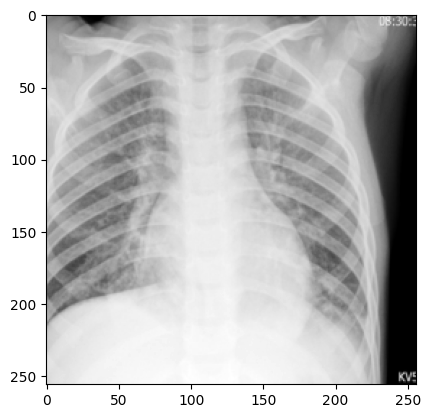

In [105]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Rescaling
image = T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33))(image)

# Remove the batch dimension for displaying
image = image.squeeze(0)

# Display the image
plt.imshow(image.squeeze(), cmap='grey')  
plt.show()

### Random Shifting

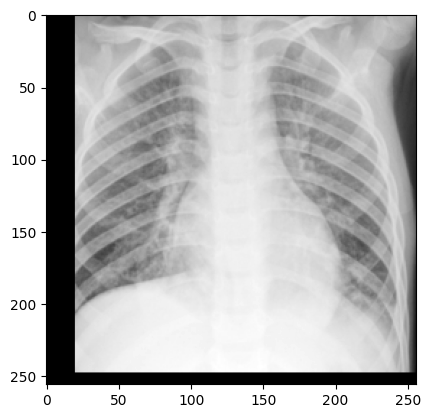

In [106]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Shifts image horizontally or vertically by 10%
image = T.RandomAffine(degrees=0, translate=(0.1, 0.1))(image)

# Remove the batch dimension for displaying
image = image.squeeze() 

plt.imshow(image, cmap='grey')  
plt.show()

### Random Changes to Brightness & Contrast

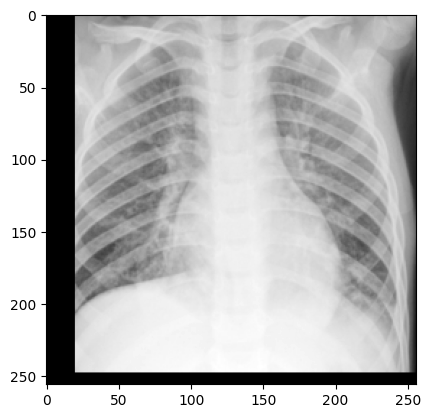

In [107]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Randomly changes brightness and contrast
T.ColorJitter(brightness=0.2, contrast=0.2)(image)

# Remove the batch dimension for displaying
image = image.squeeze()  # Now image is (C, H, W) again

plt.imshow(image, cmap='grey')  
plt.show()

### Random Rotation

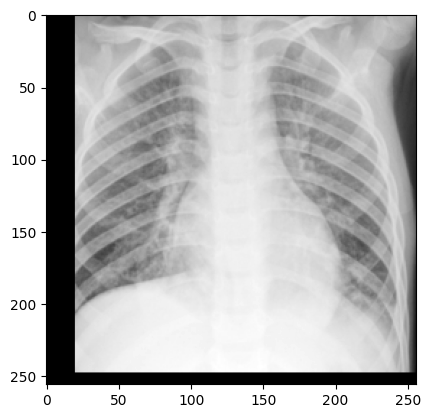

In [108]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Randomly changes brightness and contrast
T.RandomRotation(degrees=10)(image)

# Remove the batch dimension for displaying
image = image.squeeze()  # Now image is (C, H, W) again

plt.imshow(image, cmap='grey')  
plt.show()

# Create Separate DataFrames & Summary of Labels

In [109]:
# Creating a separate DataFrame for each dataset
test_df = df.loc[df.loc[:, 'split'] == 'test']
train_df = df.loc[df.loc[:, 'split']=='train']
val_df = df.loc[df.loc[:, 'split'] == 'val']

# Count the occurrences of each label
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()
test_counts = test_df['label'].value_counts().sort_index()

# Prepare Data for summary table
summary_data = {
    'Normal': [train_counts.get(0, 0), val_counts.get(0, 0), test_counts.get(0, 0)],
    'Pneumonia': [train_counts.get(1, 0), val_counts.get(1, 0), test_counts.get(1, 0)]
}

# Create a summary table
summary_df = pd.DataFrame(summary_data, index=['Train', 'Validation', 'Test'])
summary_df

,Normal,Pneumonia
Train,1341,3875
Validation,8,8
Test,234,390


# Data Loader

In [110]:
# Defining path for each dataset
test_dir = os.path.join(alt_directory, 'test')
train_dir = os.path.join(alt_directory, 'train')
val_dir = os.path.join(alt_directory, 'val')

# Creating a CustomImageDataset object for each dataset
training_data = CustomImageDataset(train_df, test_dir, augmentations)
val_data = CustomImageDataset(val_df, train_dir, normalizations)
test_data = CustomImageDataset(test_df, val_dir, normalizations)

# Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through Training DataLoader

In [111]:
# Code Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterate-through-the-dataloader

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[21].squeeze() # Change the index (0 to 63) to display a different image in batch
label = train_labels[1] # [0] for Normal & [1] for Pneumonia

img = img.permute(1, 2, 0)  # Change the shape to (256, 256, 3)
plt.imshow(img)
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 3, 256, 256])


AttributeError: 'tuple' object has no attribute 'size'